# Projekt - KM3
Zbiór danych: https://archive.ics.uci.edu/ml/datasets/Polish+companies+bankruptcy+data

In [1]:
import os

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, auc, f1_score, classification_report, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier
import xgboost as xgb

import random
import scipy.stats
import joblib

plt.rcParams['figure.figsize'] = (16,6)
sns.set(font_scale = 1.2)
sns.set_style("ticks",{'axes.grid' : True})
sns.set_palette("deep")

### Podsumowanie po KM1
* firmy, które zbankrutowały, stanowią niewielką liczbę wszystkich obserwacji, ok. 5%
* możemy usunąć kolumny `X27`, `X21`, `X37` ze względu na dużą liczbę braków danych
* możemy usunąć w większości puste wiersze
* należy zapełnić braki danych w kolumnach, ponieważ każda kolumna pewne braki ma; najlepiej przez medianę, ze względu na wartości odstające
* żadna kolumna nie wydaje się być szczególnie mocno skorelowana z naszymi docelowymi kategoriami
* istnieją grupy bardzo mocno skorelowanych zmiennych; można rozważyć zostawienie tylko jednej kolumny z każdej grupy
* można rozważyć noramlizację zmiennych, ponieważ występuja one w różnych rzędach wielkości 
* wszystkie zmienne mają bardzo dużo wartości odstających oraz koncentrują się w okolicach zera (poza `X27`)
* nie możemy usunąć obserwacji o wielu wartościach odstających, ponieważ byśmy pozbyli się wielu firm, które zbankrutowały

### Podsumowanie po KM2
Wydaje się, że RandomForest oraz XGBoost to jest najbardziej obiecujące modele.

## Przygotowanie danych

In [2]:
df = pd.read_csv(os.path.join('data', 'dataset.csv'))
df.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class,bankruptcy_after,year
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,0,0,1
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,0,0,1
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,0,0,1
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,0,0,1
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,0,0,1


In [3]:
y = df['class']
y2 = df['bankruptcy_after']
X = df.drop(['class', 'bankruptcy_after', 'year'], axis = 1)

# usunięcie kolumn z wieloma brakami
X = X.drop(["Attr27","Attr21","Attr37"], axis = 1)

colnames = X.columns

# usuwamy wiersze, ktore mają więcej niż 7 brakujących wartości
y = y[X.isna().sum(axis=1) <= 7]
y2 = y2[X.isna().sum(axis=1) <= 7]
X = X[X.isna().sum(axis=1) <= 7]

# usuwanie kolumn silnie skorelowanych z innymi - do przetestowania
class ColumnRemover(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        tmp = pd.DataFrame(X, columns=np.array([*colnames, 'outliers_count']))
        columns_to_drop = ['Attr51', 'Attr2','Attr50', 'Attr4','Attr14', 'Attr18', 'Attr7', 'Attr8', 'Attr36', 'Attr63', 'Attr9', 'Attr10', 'Attr26', 'Attr12', 'Attr31', 'Attr19','Attr43', 'Attr44', 'Attr49', 'Attr56', 'Attr58', 'Attr20','Attr48', 'Attr63', 'Attr22', 'Attr52', 'Attr32', 'Attr34','Attr64', 'Attr53']
        return tmp.drop(columns_to_drop, axis = 1)

# przycinanie outlierów + dodanie kolumny informującej o ich liczbie
class OutlierCutter(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._Q025 = None
        self._Q975 = None
    
    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        self._Q025 = X.quantile(0.025)
        self._Q975 = X.quantile(0.975)
        return self

    def transform(self, X):
        tmp = pd.DataFrame(X.copy())
        
        tmp['outliers_count'] = ((tmp < self._Q025) | (tmp > self._Q975)).sum(axis=1)
        
        for col in tmp.columns[:-1]:
            tmp.loc[tmp[col] < self._Q025[col], col] = self._Q025[col]
            tmp.loc[tmp[col] > self._Q975[col], col] = self._Q975[col]
        return tmp
    
preprocessing = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='median'),  # zastępujemy braki danych w kolumnach medianą
    OutlierCutter(),
    StandardScaler()
)

### Podział danych na zbiory treningowy, testowy i walidcyjny
Podział w proporcji 60% / 20% / 20%. Zbiór walidcyjny będzie zachowany do finlalnej ewalucji modelu.

In [4]:
X_train_test, X_val, y_train_test, y_val = train_test_split(X, y, random_state=2137, test_size=0.2, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X_train_test, y_train_test, random_state=420, test_size=0.25, stratify=y_train_test)
print(f'Zbiór treningowy: {X_train.shape}')
print(f'Zbiór testowy: {X_test.shape}')

Zbiór treningowy: (25896, 61)
Zbiór testowy: (8632, 61)


In [5]:
X_train = preprocessing.fit_transform(X_train, y_train)

X_test = preprocessing.transform(X_test)
X_val = preprocessing.transform(X_val)

### Miary oceny jakości klasyfikatora
Za główną miarę przyjmujemy **f1-score**, ale będziemy również spoglądać na:
* precision / recall
* confusion matrix
* roc auc

In [6]:
## procedury pomocnicze

# precision / recall
def print_precision_recall_report(clf, X_train, y_train, X_test, y_test):
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    # tabelki precision / recall / f1
    def print_precision_recall_table(y, y_pred, title='Zbiór ...'):
        print('{:-^29}'.format(title))
        print(pd.DataFrame(classification_report(
                y, y_pred,
                output_dict = True
            )).iloc[:-1, :-3].to_string())
        print()

    print_precision_recall_table(y_train, y_train_pred, 'Zbiór treningowy')
    print_precision_recall_table(y_test, y_test_pred, 'Zbiór testowy')

    # macierz pomyłek
    def plot_confusion_matrix(y, y_pred, title, ax):
        conf_mx = confusion_matrix(y, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_mx, display_labels=[0, 1])
        disp.plot(colorbar=False, cmap=plt.cm.Blues, ax=ax, values_format='d')
        ax.grid(False)
        ax.set_title(title)
        
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    plot_confusion_matrix(y_train, y_train_pred, 'Zbiór treningowy', axs[0])
    plot_confusion_matrix(y_test, y_test_pred, 'Zbiór testowy', axs[1])
    axs[1].set_ylabel(None)
    plt.show()
    
# roc auc
def plot_roc_auc(clf, X_train, y_train, X_test, y_test):
    def fpr_tpr_rocauc(X, y):
        y_score = clf.predict_proba(X)[:, 1]
        fpr, tpr, _ = roc_curve(y, y_score)
        roc_auc = auc(fpr, tpr)
        return (fpr, tpr, roc_auc)
    
    fpr_train, tpr_train, roc_auc_train = fpr_tpr_rocauc(X_train, y_train)
    fpr_test, tpr_test, roc_auc_test = fpr_tpr_rocauc(X_test, y_test)

    plt.figure(figsize=(5, 5))
    plt.plot(fpr_train, tpr_train, color="steelblue", lw=2, label="Train ROC curve (area = %0.2f)" % roc_auc_train)
    plt.plot(fpr_test, tpr_test, color="darkorange", lw=2, label="Test ROC curve (area = %0.2f)" % roc_auc_test)

    plt.plot([0, 1], [0, 1], color="black", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Krzywa ROC")
    plt.legend(loc="lower right")
    plt.show()

## Random Forest
Przy KM2 ten model bardzo dopasował się do danych trenignowych i na zbiorze testowym osiągnął mizerne wyniki. Spróbujemy temu zaradzić przez optymalizację hiperparametrów.

In [7]:
rf_random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=0),
    {
        'n_estimators': [300, 400, 500, 600, 700],
        'max_depth': [2, 4, 6, 8, 10, None],
        'min_samples_split': [2, 4, 6, 10, 15, 20],
        'min_samples_leaf': [1, 5, 10, 15, 20, 50],
        'max_features': [2, 4, 6, "auto", 10],
        'max_leaf_nodes': [50, 75, 100, 150],
        'class_weight': ['balanced', None]
    },
    n_iter = 300,
    scoring = 'f1',
    n_jobs = 5,
    cv = 3,
    random_state = 42
)
# rf_random_search.fit(X_train, y_train)
# joblib.dump(rf_random_search, 'search/rf_random_search.pkl');
rf_random_search = joblib.load('search/rf_random_search.pkl');

In [8]:
rf_random_search.best_params_

{'n_estimators': 400,
 'min_samples_split': 10,
 'min_samples_leaf': 20,
 'max_leaf_nodes': 150,
 'max_features': 10,
 'max_depth': None,
 'class_weight': 'balanced'}

------Zbiór treningowy-------
                  0         1
precision  0.986247  0.303426
recall     0.913394  0.747588
f1-score   0.948424  0.431655

--------Zbiór testowy--------
                  0         1
precision  0.975565  0.224510
recall     0.903736  0.551807
f1-score   0.938278  0.319164



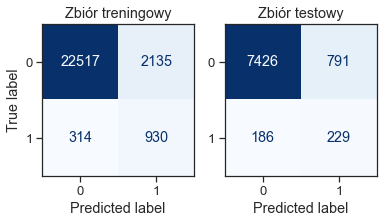

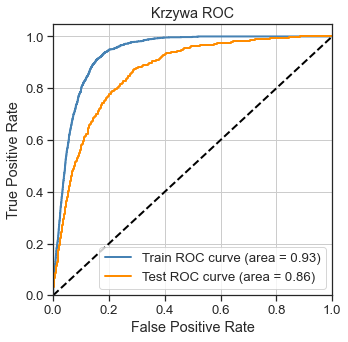

In [9]:
print_precision_recall_report(rf_random_search.best_estimator_, X_train, y_train, X_test, y_test)
plot_roc_auc(rf_random_search.best_estimator_, X_train, y_train, X_test, y_test)

Widzimy już pewną poprawę, ale widzimy, że:
* drzewa nie mają ograniczonej głębokości
* między krzywymi *roc* odpowiadającymi zbiorom trenignowemu i testowemu jest spora przerwa. 
co może świadczyć o nadal zbyt dużym dopasowaniu modelu do danych treningowych.

Mając na uwadze znalezione parametry spróbujemy raz jeszcze ich poszukać przy zawężonych kryteriach i 5-krotnej cross-walidacji.

In [10]:
rf_random_search2 = RandomizedSearchCV(
    RandomForestClassifier
    (
        n_estimators = 500,
        class_weight = 'balanced',
        random_state = 0
    ),
    {
        'max_depth': [6, 8, 10, 12],
        'min_samples_split': [10, 15, 20],
        'min_samples_leaf': [15, 20, 25],
        'max_features': [6, 8, 10, 12],
        'max_leaf_nodes': [100, 125, 150, 175, 200]
    },
    n_iter = 100,
    scoring = 'f1',
    n_jobs = 5,
    cv = 5,
    random_state = 42
)
# rf_random_search2.fit(X_train, y_train)
# joblib.dump(rf_random_search2, 'search/rf_random_search2.pkl');
rf_random_search2 = joblib.load('search/rf_random_search2.pkl')

In [11]:
rf_random_search2.best_params_

{'min_samples_split': 15,
 'min_samples_leaf': 20,
 'max_leaf_nodes': 175,
 'max_features': 12,
 'max_depth': 12}

------Zbiór treningowy-------
                  0         1
precision  0.986118  0.369968
recall     0.936516  0.738746
f1-score   0.960677  0.493026

--------Zbiór testowy--------
                  0         1
precision  0.974572  0.267990
recall     0.928198  0.520482
f1-score   0.950820  0.353808



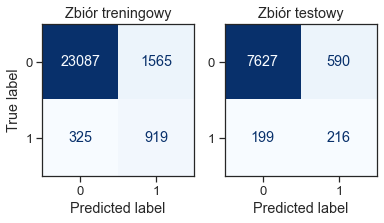

In [12]:
print_precision_recall_report(rf_random_search2.best_estimator_, X_train, y_train, X_test, y_test)

#### Podsumowanie
Z modelu *Random Forest Classifier* nic więcej nie uda nam się wycisnąć. Na zbiorze testowym uzystkaliśmy *f1-score* na poziomie 0.3538, co znacznie przewyższa wyniki wszystkich modeli przetestowanych podczas KM2. Jednak nadal wynik zdecydowanie nie jest satysfakcjonujący.

## XGBoost
XGBoost bez strojenia wypadł na tle inych modeli dośc obiecująco. Spróbujemy jescze polepszyć jego wyniki szukając odpowiednich hiperparametrów. 

#### 1. poszukiwanie - orientacja w sytuacji

In [13]:
params_rand = {
    'n_estimators': range(100, 501, 50),
    'max_depth': range(2, 10, 2),
    'gamma': np.arange(0, 1.0, 0.2),
    'min_child_weight': range(2, 20, 3),
    'subsample': np.arange(0.2, 1.0, 0.2),
    'colsample_bytree': np.arange(0.2, 1.0, 0.2)
}

model_xgb = RandomizedSearchCV(
    XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=0), 
    params_rand, 
    scoring = 'f1', 
    cv = 5, 
    verbose = 5, 
    random_state = 42, 
    n_jobs = 5, 
    n_iter = 50
)

In [14]:
np.arange(0, 1.0, 0.2)

array([0. , 0.2, 0.4, 0.6, 0.8])

In [15]:
# model_xgb.fit(X_train, y_train)
# joblib.dump(model_xgb, 'search/xgb_random_search.pkl');
model_xgb = joblib.load('search/xgb_random_search.pkl')

In [16]:
model_xgb.best_params_

{'subsample': 0.8,
 'n_estimators': 350,
 'min_child_weight': 14,
 'max_depth': 6,
 'gamma': 0.2,
 'colsample_bytree': 0.8}

------Zbiór treningowy-------
                  0         1
precision  0.999351  0.998374
recall     0.999919  0.987138
f1-score   0.999635  0.992724

--------Zbiór testowy--------
                  0         1
precision  0.967211  0.750000
recall     0.994402  0.332530
f1-score   0.980618  0.460768



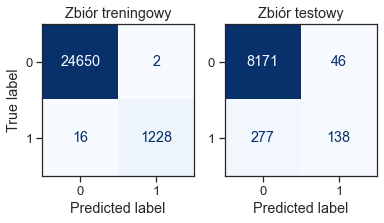

In [17]:
print_precision_recall_report(model_xgb.best_estimator_, X_train, y_train, X_test, y_test)

#### 2. poszukiwanie - zawężenie siatki parametrów
Zawężamy przestrzeń parametrów, którą teraz przeszukamy za pomocą `GridSearchCV`.

In [18]:
params = {
    'min_child_weight': [8, 10, 12, 14, 16],
    'max_depth': [3, 6, 9]
}

model2_xgb = GridSearchCV(
    XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=0, n_estimators=600), 
    params, 
    scoring = 'f1', 
    cv = 5, 
    verbose = 3, 
    n_jobs= 5
)

In [19]:
# model2_xgb.fit(X_train, y_train)
# joblib.dump(model2_xgb, 'search/model2_xgb.pkl');
model2_xgb = joblib.load('search/model2_xgb.pkl')

In [20]:
model2_xgb.best_params_

{'max_depth': 6, 'min_child_weight': 8}

#### 3. poszukiwanie - poprawka
Wydaje się, że parametr `min_child_weight` chce przyjąć jeszcze mniejsze wartości. Sprawdźmy to.

In [21]:
params = {
    'min_child_weight': [1, 2, 4, 6],
    'max_depth': [3, 6]
}

model3_xgb = GridSearchCV(
    XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=0, n_estimators=600), 
    params, 
    scoring = 'f1', 
    cv = 5, 
    verbose = 3, 
    n_jobs= 5
)

In [22]:
# model3_xgb.fit(X_train, y_train)
# joblib.dump(model3_xgb, 'search/model3_xgb.pkl');
model3_xgb = joblib.load('search/model3_xgb.pkl')

In [23]:
model3_xgb.best_params_

{'max_depth': 6, 'min_child_weight': 4}

------Zbiór treningowy-------
                  0         1
precision  1.000000  0.997594
recall     0.999878  1.000000
f1-score   0.999939  0.998796

--------Zbiór testowy--------
                  0         1
precision  0.969306  0.804124
recall     0.995375  0.375904
f1-score   0.982168  0.512315



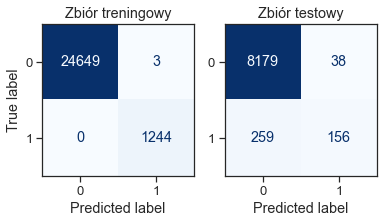

In [24]:
print_precision_recall_report(model3_xgb.best_estimator_, X_train, y_train, X_test, y_test)

Otrzymaliśmy trochę lepsze wyniki. Przebiliśmy próg 0.5 w metryce *f1*. Spójrzmy na krzywą *roc*.

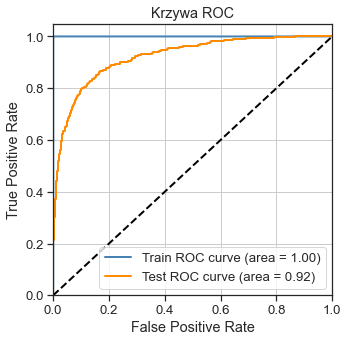

In [25]:
plot_roc_auc(model2_xgb.best_estimator_, X_train, y_train, X_test, y_test)

Widać, że model zbyt dopasował się do danych treningowych. Jednak wynik na zbiorze testowym to najlepsze, co udało się nam dotychczas osiągnąć.

### XGBoost z ustawionymi wagami klas

In [26]:
scale_pos_weight = (y_train == 0).sum() / (y == 1).sum()
scale_pos_weight

11.886210221793636

In [27]:
xgb_balanced = GridSearchCV(
    XGBClassifier(
        n_estimators = 400,
        scale_pos_weight = scale_pos_weight,
        objective = 'binary:logistic', 
        eval_metric = 'logloss', 
        random_state = 0
    ), 
    {
        'max_depth': [2, 4, 6, 8],
        'min_child_weight': [2, 4, 6],
    }, 
    scoring = 'f1', 
    cv = 5, 
    verbose = 5, 
    n_jobs = -1, 
)
# xgb_balanced.fit(X_train, y_train)
# joblib.dump(xgb_balanced, 'search/xgb_balanced.pkl');
xgb_balanced = joblib.load('search/xgb_balanced.pkl')

In [28]:
xgb_balanced.best_params_

{'max_depth': 6, 'min_child_weight': 4}

------Zbiór treningowy-------
                  0         1
precision  1.000000  0.997594
recall     0.999878  1.000000
f1-score   0.999939  0.998796

--------Zbiór testowy--------
                  0         1
precision  0.972415  0.713178
recall     0.990994  0.443373
f1-score   0.981617  0.546805



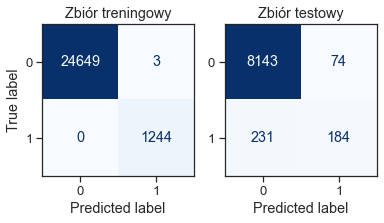

In [29]:
print_precision_recall_report(xgb_balanced.best_estimator_, X_train, y_train, X_test, y_test)

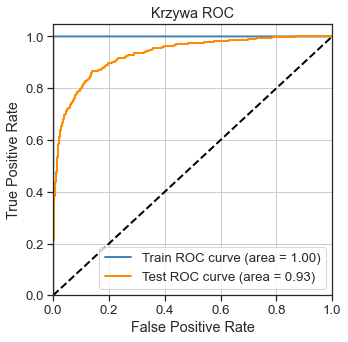

In [30]:
plot_roc_auc(xgb_balanced.best_estimator_, X_train, y_train, X_test, y_test)

Jak widzimy, ustawienie wag dla klas docelowych daje jeszcze bardziej obiecujący wynik.

*XGBoost w ustawionym parametrem `scale_pos_weight` wymaga bardziej dogłębnego zbadania. Nie wzieliśmy poprawki na długi czas poszukiwania hiperparametrów i teraz brakuje nam czasu.*

### Dodatek - usuwanie kolumn silnie skorelowanych
Kiedyś na etapie analizy danych rozważaliśmy pomysł, żeby usunąć kolumny silnie skorelowane. Jednak teraz pogorszyło to wynik (lecz być może wymagało by to osobnego poszukiwania hiperparametrów).

In [31]:
cr = make_pipeline(
    ColumnRemover(),
    XGBClassifier(
        n_estimators = 400,
        max_depth = 6,
        min_child_weight = 4,
        scale_pos_weight = scale_pos_weight,
        objective = 'binary:logistic', 
        eval_metric = 'logloss', 
        random_state = 0
    )
)

cr.fit(X_train, y_train)
f1_score(y_test, cr.predict(X_test))

0.46461538461538465

## Podsumowanie

Nie zależy nam na priorytetyzacji *precision* lub *recall*. Dlatego nasza główna metryka to *f1-score*. Zerkamy też na krzywą *roc* i miarę *auc*. 

Optymalizacja hiperparametrów przyniosła zamierzony efekt:
* `RandomForest` zwiększył swój wynik z 0.09 na 0.35 na zbiorze testowym;
* `XGBoost` zwiększył swój wynik:
    * z 0.21 na 0.51 na zbiorze testowym (bez wag klas);
    * z 0.27 na 0.54 na zbiorze testowym (z wagami klas);

XGBoost ponownie dał najlepsze wyniki. Niepokoi nas odrobinę tak wysoki wynik na zbiorze trenigowym. Musimy to jeszcze zbadać. Jednakowoż jesteśmy zadowoleni z postępów.

